# Microsoft Stock Time-Series Analysis

![Microsoft Logo](Images/microsoft_logo_02.jpeg)

## Business Problem

In today's world, it is not enought to just rely on your main income. Your hard-earned money needs to be invested correctly. I was tasked to analyze Microsoft Stock to see if it is right for you to invest in. Moreover, I need to see if I can come up with a model that can reliably forecast future MSFT stock price. Based on the entire MSFT historical stock data that we have, we use time-series analysis to analyze, test and build the mest model that provides future stock price.

In [1]:
# Importing Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [2]:
# Reading in the Data, setting the datetime as index

df = pd.read_csv('Data/MSFT.csv', index_col='Date', parse_dates=True)

Since this is a time-series analysis, we use the "Date" column as index.

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-19,371.489990,373.260010,369.839996,373.260010,373.260010,20603700
2023-12-20,375.000000,376.029999,370.529999,370.619995,370.619995,26316700
2023-12-21,372.559998,374.410004,370.040009,373.540009,373.540009,17708000
2023-12-22,373.679993,375.179993,372.709991,374.579987,374.579987,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,374.660004,12673100


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9524 entries, 1986-03-13 to 2023-12-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9524 non-null   float64
 1   High       9524 non-null   float64
 2   Low        9524 non-null   float64
 3   Close      9524 non-null   float64
 4   Adj Close  9524 non-null   float64
 5   Volume     9524 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 520.8 KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9524.000000,9524.000000,9524.000000,9524.000000,9524.000000,9.524000e+03
mean,52.820706,53.383050,52.249194,52.836106,47.328041,5.733974e+07
std,78.772359,79.565262,77.951983,78.800088,78.820530,3.815727e+07
min,0.088542,0.092014,0.088542,0.090278,0.055969,2.304000e+06
25%,5.523438,5.615967,5.446045,5.529297,3.427964,3.300222e+07
50%,27.200001,27.469999,26.969999,27.219999,19.103065,5.049085e+07
75%,45.437500,46.060626,44.870001,45.471562,35.911209,7.123635e+07
max,383.760010,384.299988,378.160004,382.700012,382.700012,1.031789e+09


In [7]:
# Average Stock Price in the past 52 weeks

rolling_mean_52weeks = df['Close'].rolling(window=52, min_periods=1).mean()
rolling_mean_52weeks

Date
1986-03-13      0.097222
1986-03-14      0.098958
1986-03-17      0.100116
1986-03-18      0.100043
1986-03-19      0.099653
                 ...    
2023-12-19    356.371157
2023-12-20    357.205003
2023-12-21    358.045772
2023-12-22    358.934041
2023-12-26    359.746348
Name: Close, Length: 9524, dtype: float64

In [8]:
# Creating a Series of MSFT close price

df_close = df['Close']
df_close.head()

Date
1986-03-13    0.097222
1986-03-14    0.100694
1986-03-17    0.102431
1986-03-18    0.099826
1986-03-19    0.098090
Name: Close, dtype: float64

We are mainly interested in the Closing price of the MSFT stock price

### Time-Series Visualization

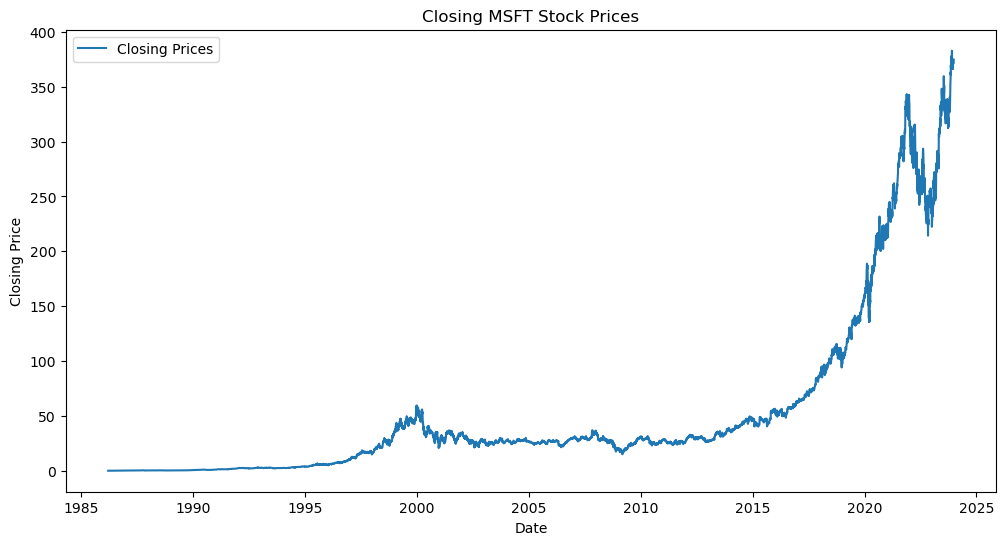

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(df_close.index, df_close, label='Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing MSFT Stock Prices')
plt.legend()
plt.show();

#### Takeaway

- We can see that the MSFT stock price is higher than ever.
- We can already see the upward trend, looks like exponential trend, in the past 7 years.

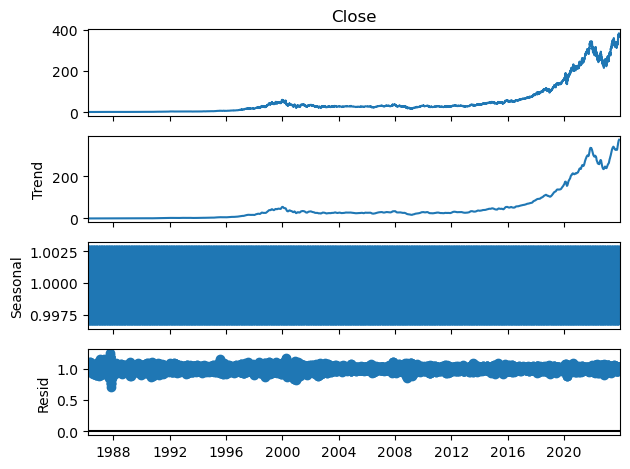

In [10]:
# Decompose the time series data into trend, seasonality, and residual components to identify patterns

result = seasonal_decompose(df_close, model='multiplicative', period=30)
result.plot()
plt.show();

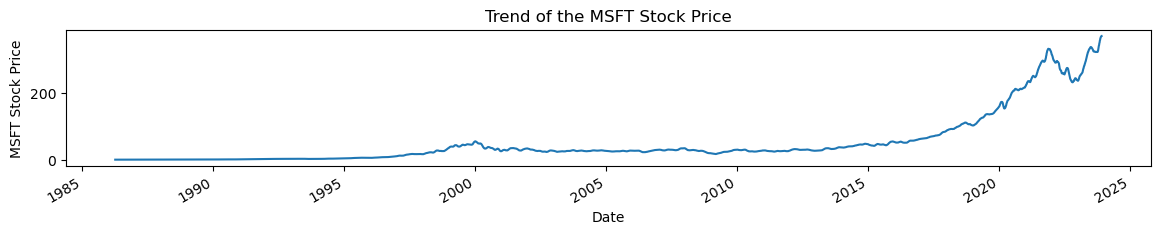

In [11]:
# Looking at the trend with more detail

decomposition_trend = result.trend
ax = decomposition_trend.plot(figsize=(14, 2))
ax.set_xlabel('Date')
ax.set_ylabel('MSFT Stock Price')
ax.set_title('Trend of the MSFT Stock Price')
plt.show();

#### Takeaway

- Looking at the graph, we see an upward trend since 2016.
- There is a minor dip between 2021-2022. From outside research, this can be attributed to the inflation, which affected all of the tech industry.

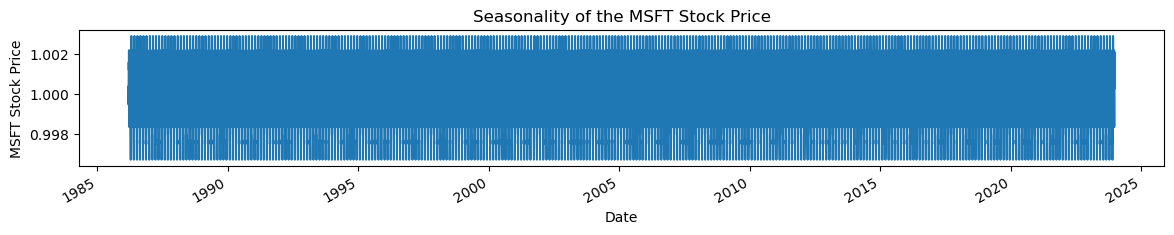

In [12]:
# Looking at the seasonality with more detail

decomposition_seasonality = result.seasonal
ax = decomposition_seasonality.plot(figsize=(14, 2))
ax.set_xlabel('Date')
ax.set_ylabel('MSFT Stock Price')
ax.set_title('Seasonality of the MSFT Stock Price')
plt.show();

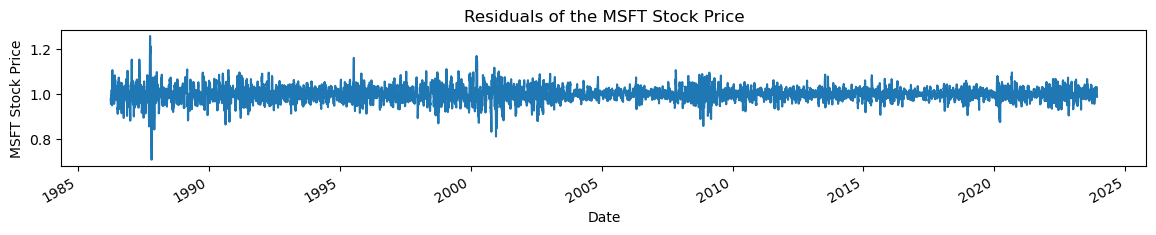

In [13]:
# Looking at the residuals with more detail

decomposition_residuals = result.resid
ax = decomposition_residuals.plot(figsize=(14, 2))
ax.set_xlabel('Date')
ax.set_ylabel('MSFT Stock Price')
ax.set_title('Residuals of the MSFT Stock Price')
plt.show();

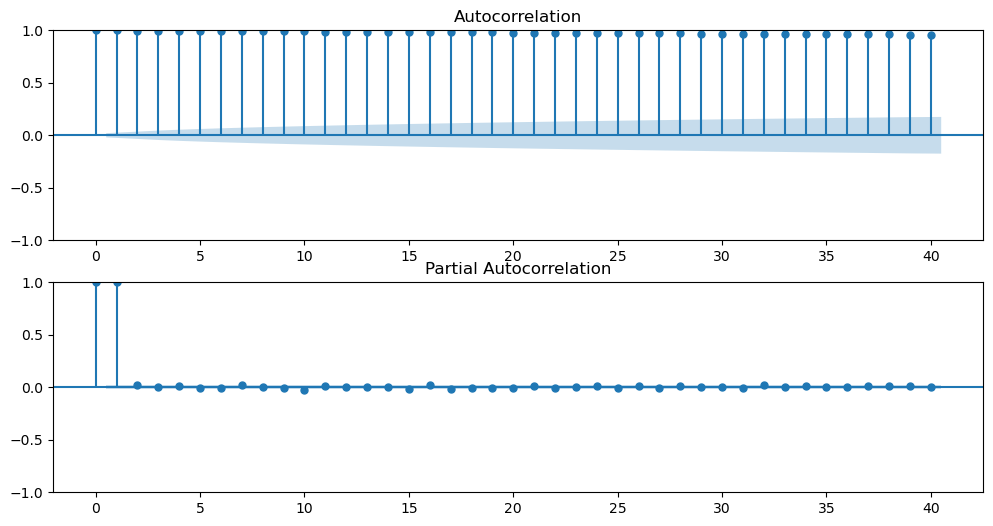

In [14]:
# Check autocorrelation and partial autocorrelation functions to identify lag dependencies

plt.figure(figsize=(12, 6))
plot_acf(df_close, lags=40, ax=plt.subplot(2, 1, 1))
plot_pacf(df_close, lags=40, ax=plt.subplot(2, 1, 2))
plt.show();

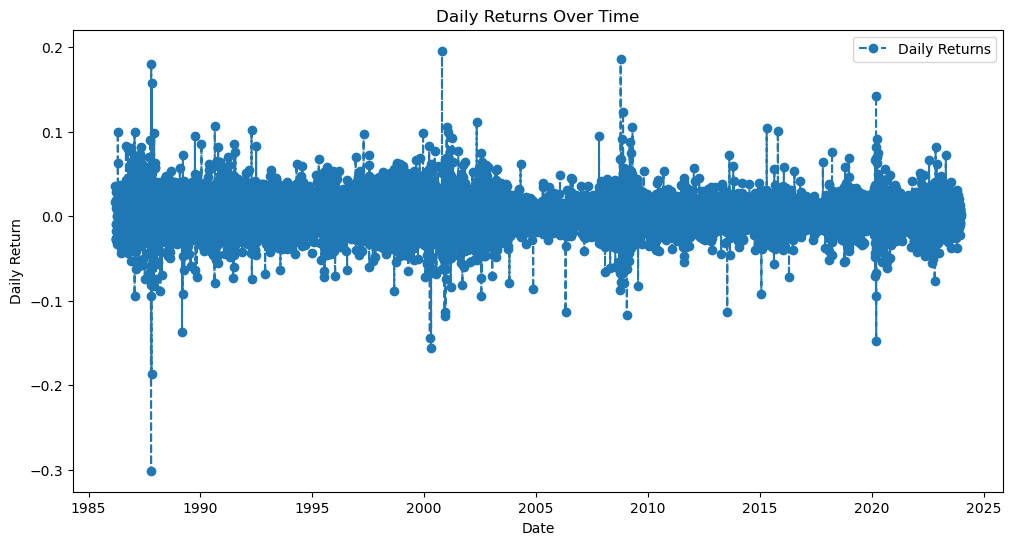

In [15]:
# Calculate and visualize daily returns to understand volatility

df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily_Return'], label='Daily Returns', linestyle='--', marker='o')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns Over Time')
plt.legend()
plt.show();

## Stationarity

### Testing for Stationarity: Dickey-Fuller Test

In [16]:
result_df = adfuller(df_close)

print('Results of Dickey-Fuller Test on MSFT Stock Price')
print('ADF Statistic: %f' % result_df[0])
print('P-Value: %f' % result_df[1])
print('Critical Values:')
for key, value in result_df[4].items():
    print('\t%s: %.3f' % (key, value))

Results of Dickey-Fuller Test on MSFT Stock Price
ADF Statistic: 4.149616
P-Value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### Takeaway

Dickey-Fuller test is a statistical test used to determine the presence of a unit root in a time series data, which is indicative of non-stationarity.

- Test statistic = 4.15


- P-value = 1.00

Since P-Value is not less than .05, we fail to reject the null hypothesis. This implies that the time-series dataset is not stationary

## Modeling

### Baseline Model: Naive Model

In [17]:
# cutoff point for Train Test Split

cutoff = round(df_close.shape[0]*0.8)
cutoff

7619

In [18]:
# Train Test Split

train = df_close[:cutoff]
test = df_close[cutoff:]

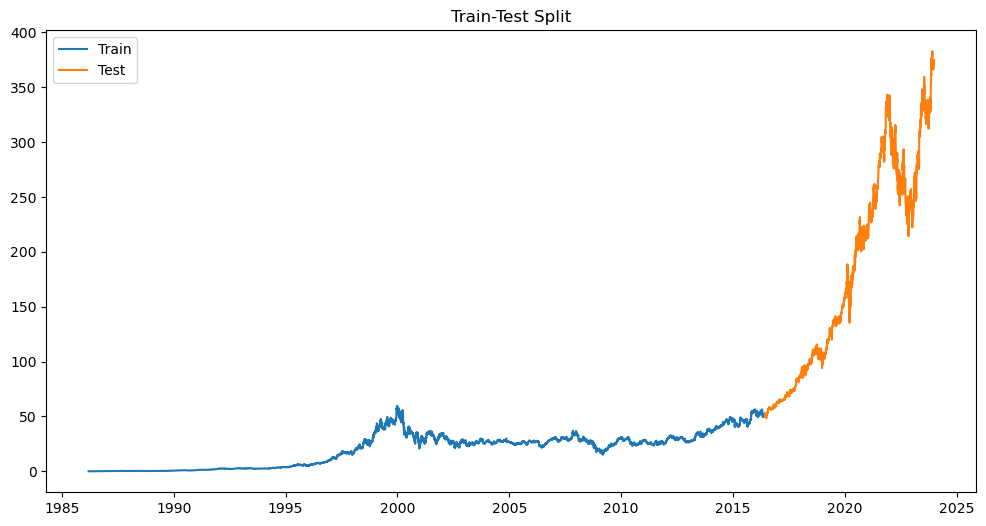

In [19]:
# Visualizing Train and Test dataset

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.set_title('Train-Test Split')
plt.legend()
plt.show();

In [20]:
naive = train.shift(1)
naive.head()

Date
1986-03-13         NaN
1986-03-14    0.097222
1986-03-17    0.100694
1986-03-18    0.102431
1986-03-19    0.099826
Name: Close, dtype: float64

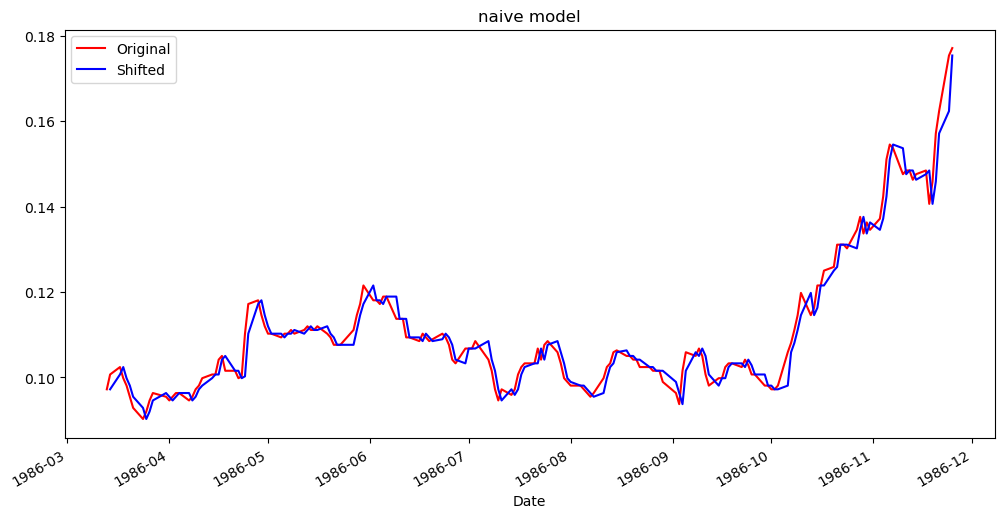

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

train[0:180].plot(ax=ax, c='r', label='Original')
naive[0:180].plot(ax=ax, c='b', label='Shifted')
ax.set_title('naive model')
ax.legend();

In [22]:
# RMSE for naive model

RMSE_naive = np.sqrt(mean_squared_error(train[1:], naive.dropna()))
RMSE_naive

0.5185768725506724

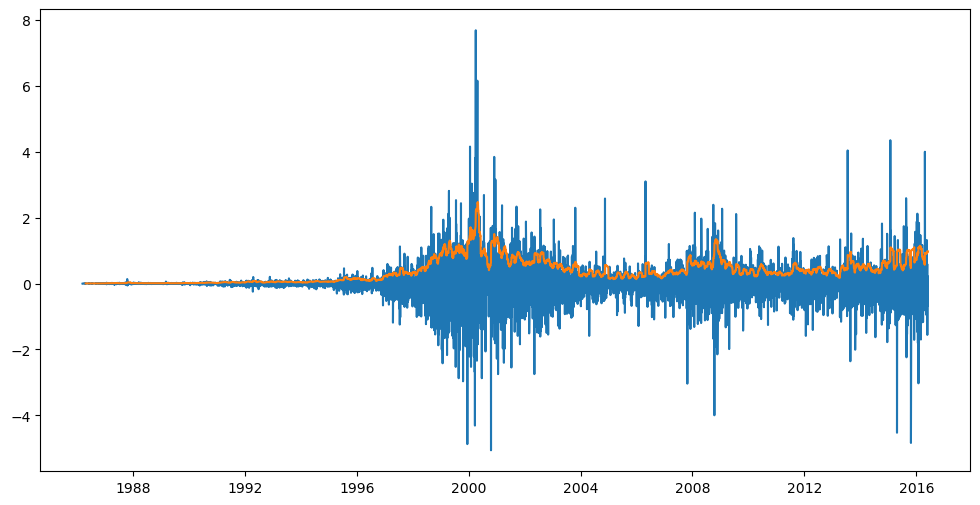

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

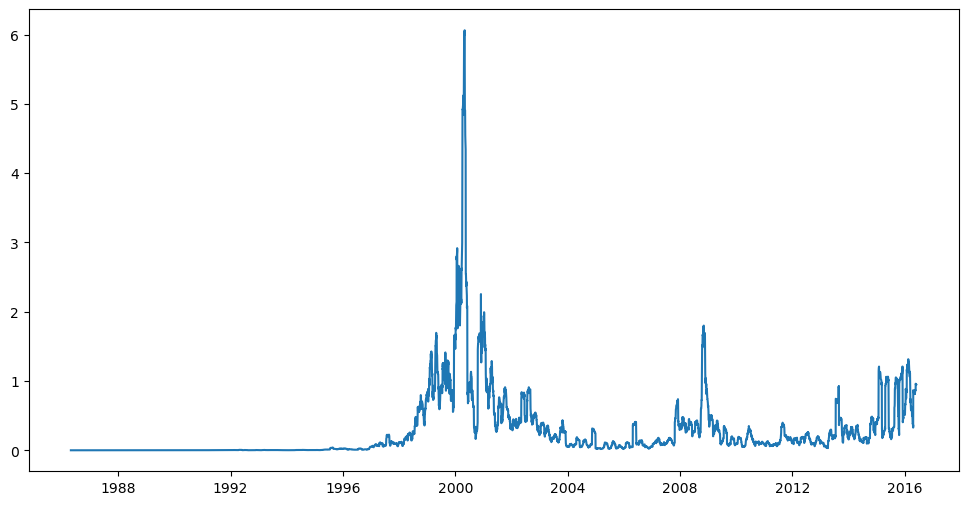

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(residuals.index, residuals.rolling(30).var());

In [25]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val}")
print('so we can safely assume that the differenced data is stationary')

The p-value associated with the Dickey-Fuller statistical test is 5.840222031299381e-29
so we can safely assume that the differenced data is stationary


### Making the Dataset Stationary

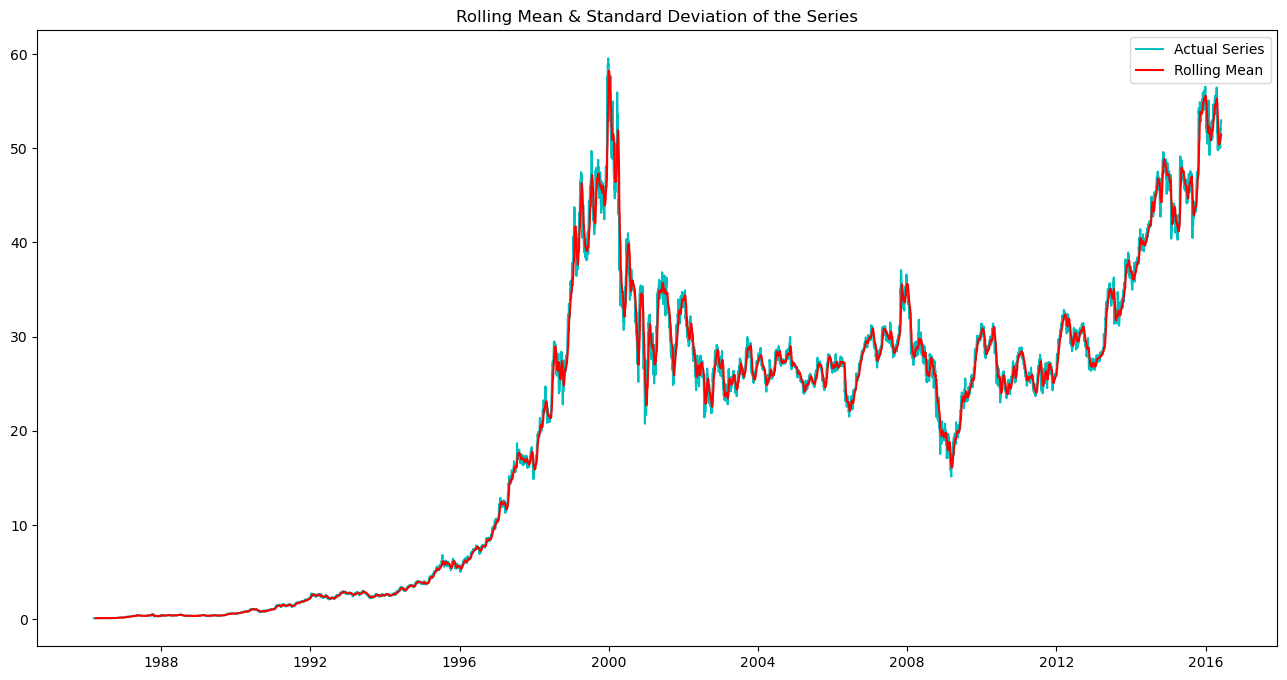

In [26]:
# Calculating the rolling mean and standard deviation for a window of 12 observations

rolmean= train.rolling(window=12).mean()
rolstd= train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show();

In [27]:
#Define a function to use adfuller test

def adfuller(train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(train.values)
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(train)

Dickey-Fuller Test: 
Test Statistic            -0.566697
p-value                    0.878331
Lags Used                 36.000000
No. of Observations     7582.000000
Critical Value (1%)       -3.431213
Critical Value (5%)       -2.861921
Critical Value (10%)      -2.566973
dtype: float64


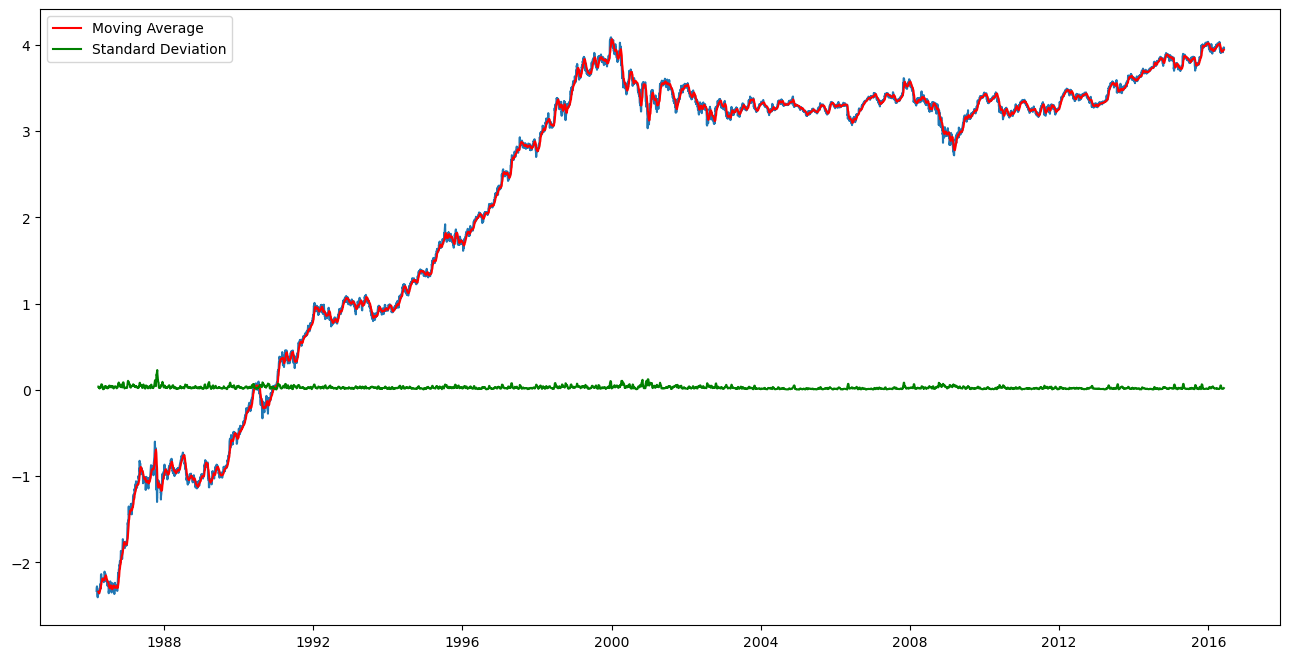

In [28]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show();

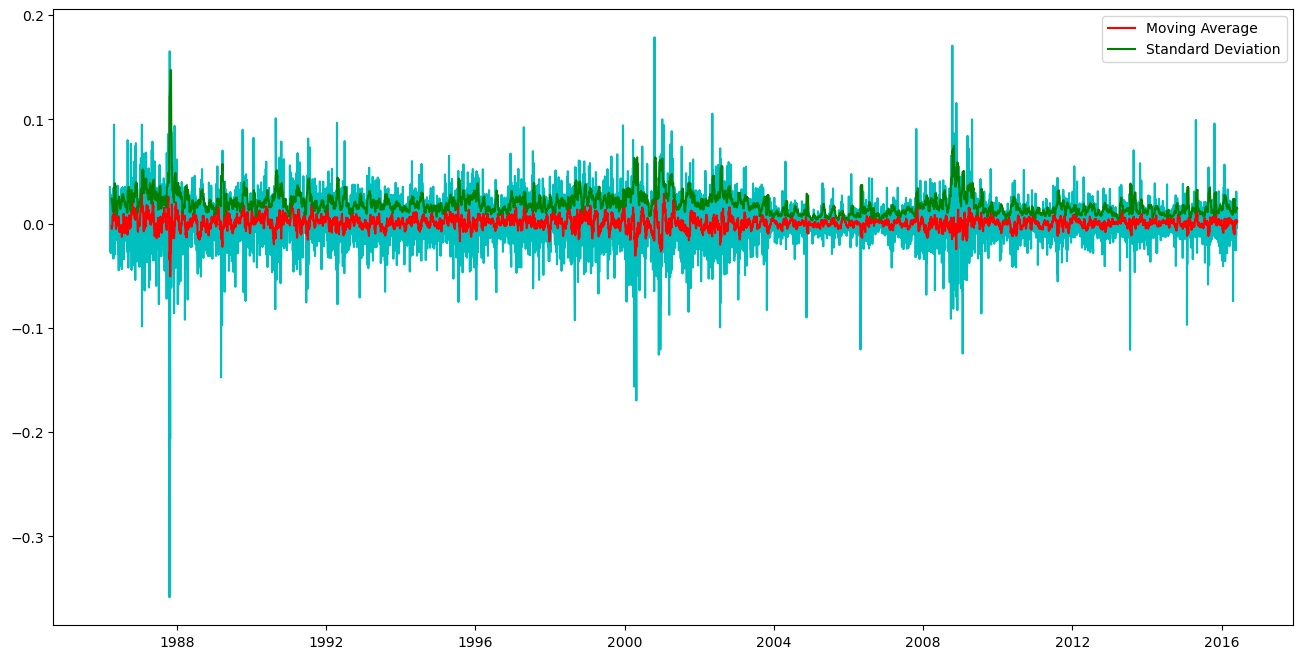

In [29]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

In [30]:
# call the adfuller function for df_shift series
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic           -46.712466
p-value                    0.000000
Lags Used                  3.000000
No. of Observations     7614.000000
Critical Value (1%)       -3.431209
Critical Value (5%)       -2.861920
Critical Value (10%)      -2.566972
dtype: float64


### AR model

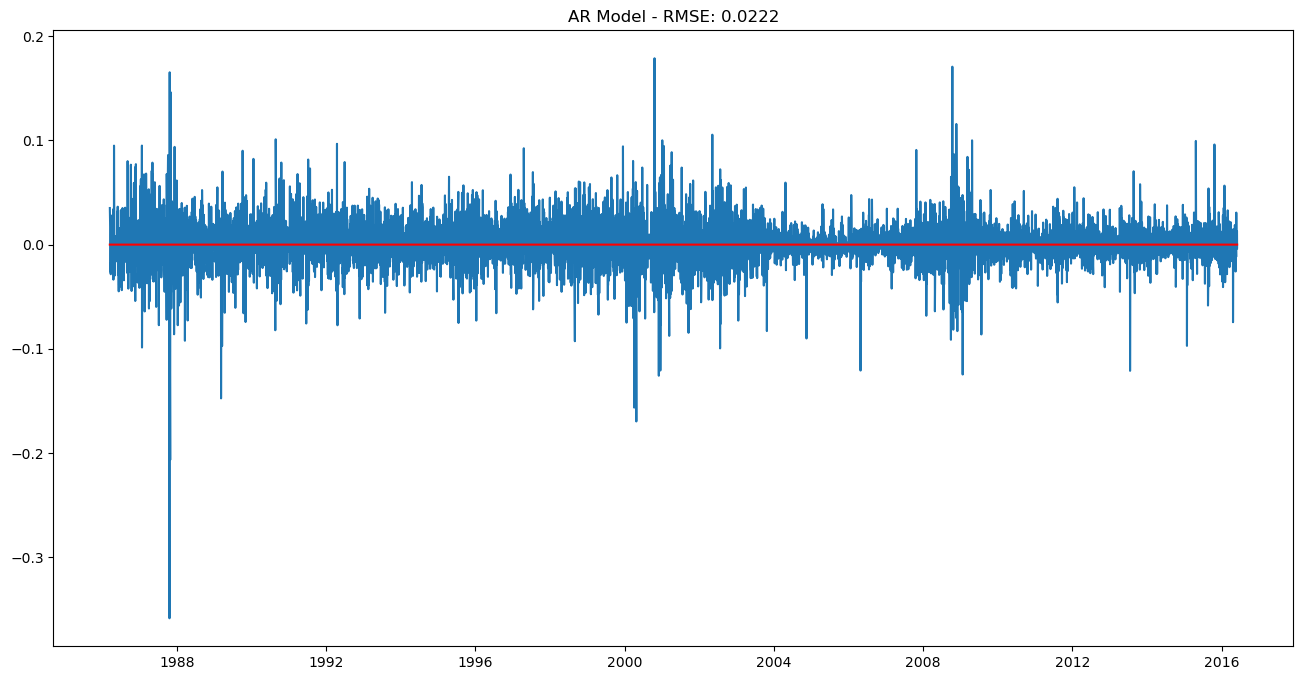

In [31]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift.values, squared=False))  #Calculating rmse
plt.show();

In [32]:
results_AR.aic

-36425.635487798674

### MA model

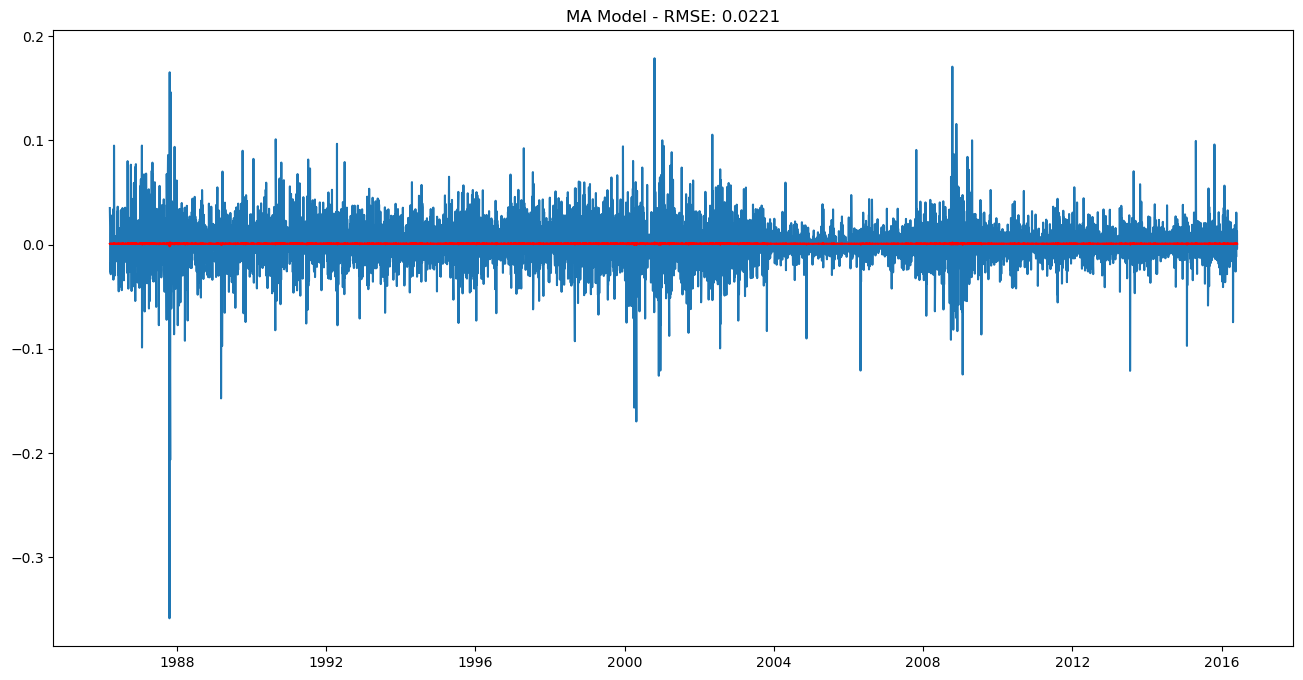

In [33]:
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 1)) #Using p=0, d=0, q=1 and apply arima function on df_shift series
results_MA = model_MA.fit()
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift.values, squared=False))
plt.show();

In [34]:
results_MA.aic

-36429.046461596634

### ARMA model

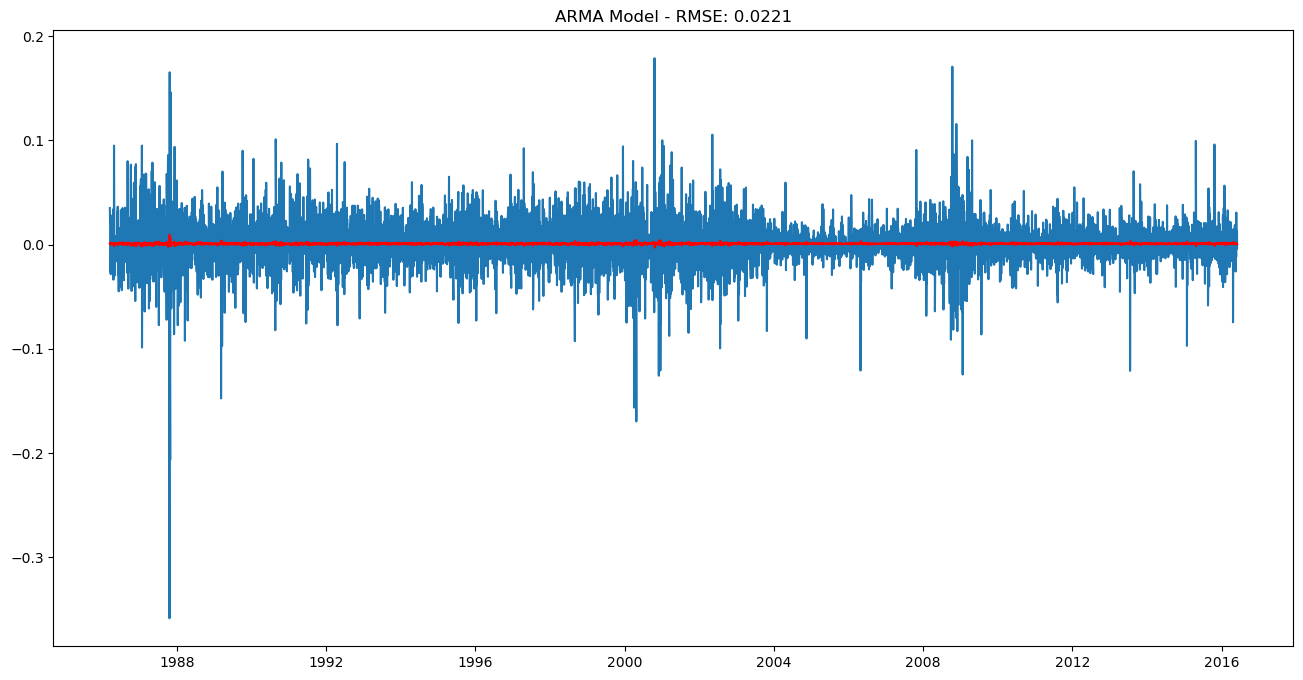

In [35]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1, 0, 1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit()
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift.values, squared=False))
plt.show();

In [36]:
results_ARMA.aic

-36430.763200799265

### ARIMA

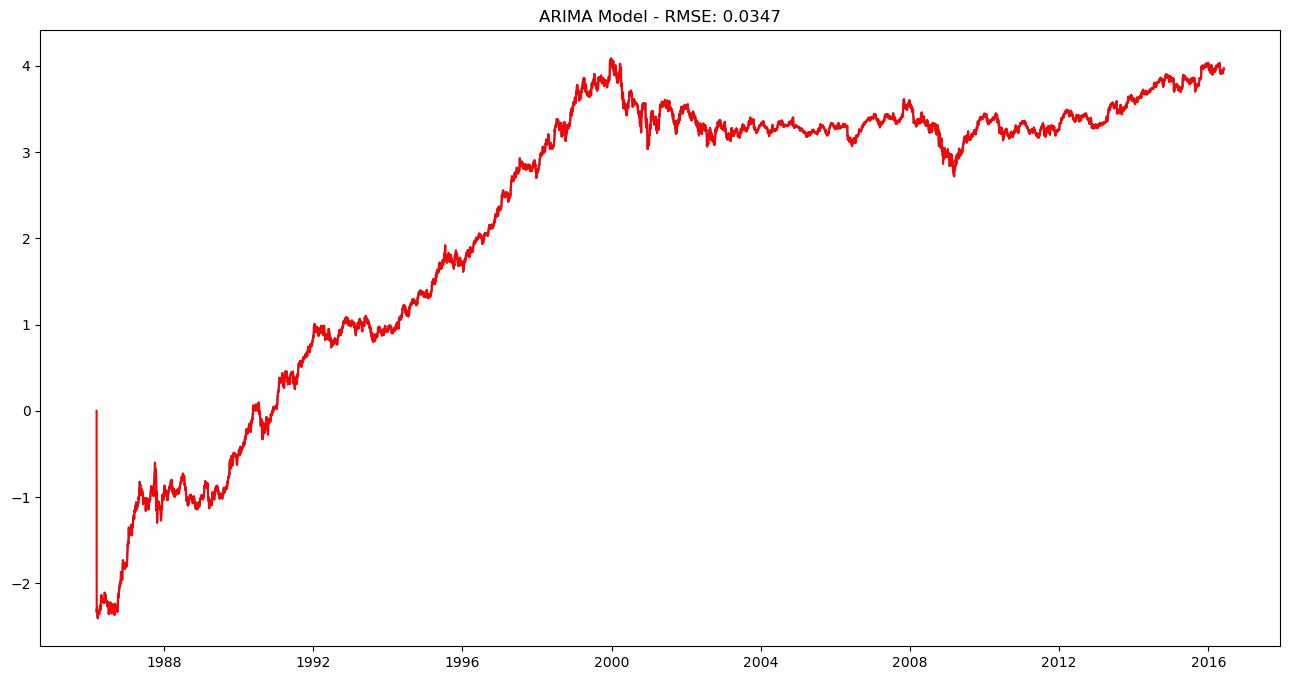

In [37]:
plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(1,1,1))  #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit()
plt.plot(df_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_log.values, squared=False))
plt.show();

In [38]:
results_ARIMA.aic

-36420.27891723337

In [39]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 7619
Model:                 ARIMA(1, 1, 1)   Log Likelihood               18213.139
Date:                Wed, 03 Jan 2024   AIC                         -36420.279
Time:                        20:42:33   BIC                         -36399.464
Sample:                             0   HQIC                        -36413.137
                               - 7619                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4623      0.302      1.530      0.126      -0.130       1.055
ma.L1         -0.4783      0.298     -1.605      0.109      -1.063       0.106
sigma2         0.0005   3.01e-06    162.887      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   4.04   Jarque-Bera (JB):             72374.19
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### LSTM Model

In [40]:
# Scaling Data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(train).reshape(-1, 1))
scaled_data.shape

(7619, 1)

In [41]:
# Create data structure with 60 time-steps and 1 output

train_size = int(len(scaled_data)*0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data), :1]

In [42]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [43]:
time_step = 100
X_train_lstm, y_train_lstm = create_dataset(train_data, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_data, time_step)

In [44]:
# Building the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (X_train_lstm.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M3 Max


2024-01-03 20:42:33.911528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-03 20:42:33.911670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [46]:
# Train the model

model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


2024-01-03 20:42:34.305459: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-03 20:42:35.333411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:42:35.576840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:42:36.038563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:42:36.458156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:42:36.879950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:42:37.363087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

94/94 [==============================] - 26s 168ms/step - loss: 0.0072
Epoch 2/100
94/94 [==============================] - 7s 71ms/step - loss: 0.0012
Epoch 3/100
94/94 [==============================] - 7s 73ms/step - loss: 0.0010
Epoch 4/100
94/94 [==============================] - 7s 74ms/step - loss: 8.1416e-04
Epoch 5/100
94/94 [==============================] - 7s 73ms/step - loss: 8.3256e-04
Epoch 6/100
94/94 [==============================] - 7s 73ms/step - loss: 6.6901e-04
Epoch 7/100
94/94 [==============================] - 7s 76ms/step - loss: 5.7790e-04
Epoch 8/100
94/94 [==============================] - 7s 76ms/step - loss: 5.5069e-04
Epoch 9/100
94/94 [==============================] - 7s 76ms/step - loss: 4.4862e-04
Epoch 10/100
94/94 [==============================] - 7s 75ms/step - loss: 4.2432e-04
Epoch 11/100
94/94 [==============================] - 7s 77ms/step - loss: 4.3026e-04
Epoch 12/100
94/94 [==============================] - 7s 75ms/step - loss: 4.0936e-04

94/94 [==============================] - 7s 78ms/step - loss: 1.1514e-04
Epoch 97/100
94/94 [==============================] - 7s 80ms/step - loss: 1.2769e-04
Epoch 98/100
94/94 [==============================] - 7s 77ms/step - loss: 1.0890e-04
Epoch 99/100
94/94 [==============================] - 7s 77ms/step - loss: 1.1760e-04
Epoch 100/100
94/94 [==============================] - 7s 77ms/step - loss: 1.2009e-04


In [47]:
train_predict = model.predict(X_train_lstm)
test_predict = model.predict(X_test_lstm)

2024-01-03 20:54:43.011145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:54:43.094228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:54:43.532723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:54:43.963670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-01-03 20:54:44.396145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 3s 76ms/step


In [48]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [49]:
# Evaluate the Model

print(np.sqrt(mean_squared_error(y_train_lstm, train_predict)))
print(np.sqrt(mean_squared_error(y_test_lstm, test_predict)))

20.570958708321683
34.572868670163736


In [50]:
# Plotting the Results

look_back = 100

trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict

In [51]:
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back)*2 + 1 : len(scaled_data) - 1, :] = test_predict

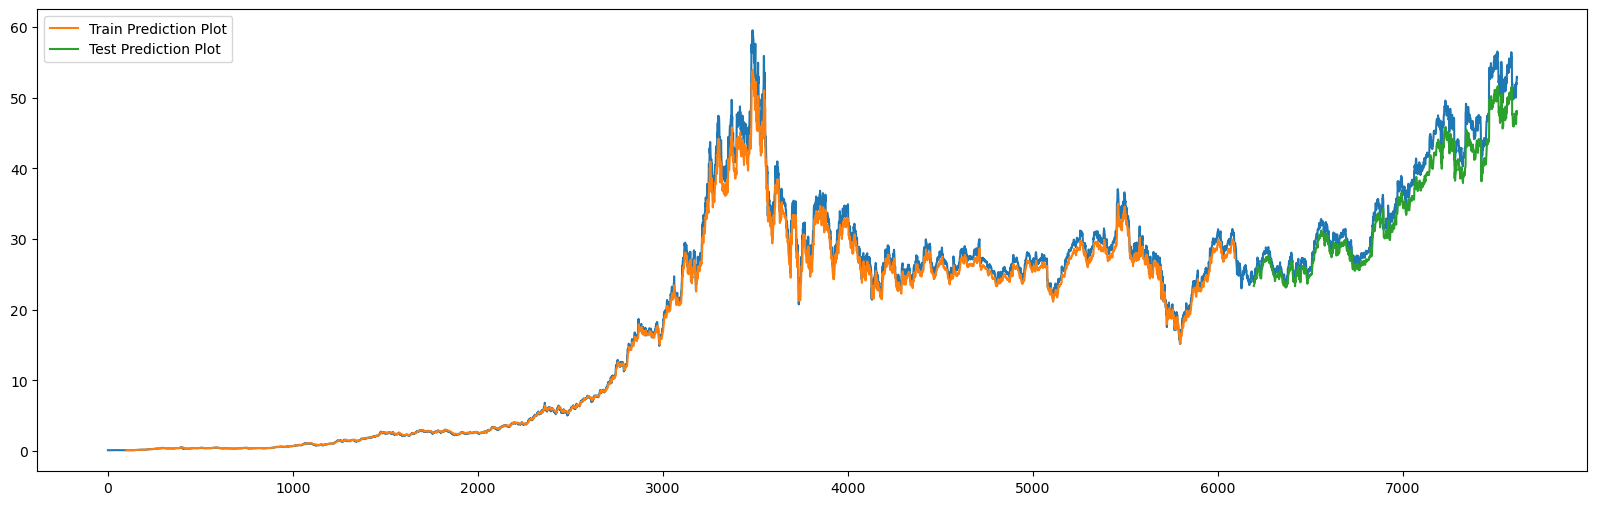

In [52]:
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot, label='Train Prediction Plot')
plt.plot(testPredictPlot, label='Test Prediction Plot')
plt.legend()
plt.show();

### Recommendations

The AIC and RMSE values for AR, MA, ARMA and ARIMA models are close to each other and better than the values for Naive model and LSTM model. However, in deciding for a reliable model, we went with LSTM model due to its ability to remember information over long periods of time, hence making it better suited for predicting stock prices. Moreover, even though the ARIMA model has lower RMSE score, it requires more time in terms of processing and works well when all of the attributes of the data set provide legitimate values.

Our analysis also showed that Microsoft stock prices have been vere high recently. This can be interpreted as high confidence from the market. Positive market reception is what we want in the company we want to invest in. Moreover, the exponential upward trend since 2016 proves that MSFT stock is only increasing in value. 

## Future Research

- **External Factors**

Stock prices are dependent upon factors outside the stock exchange. It is therefore crucial to include current events and other factors in predicting 

- **Real-Time Forecasting**

For day traders, decisions need to be made on site and in real-time. Therefore, further research needs to be done for an application to give them forecasting in real-time to make decisions at the moment.

- **Sentiment Analysis**

The stock market price is affected by current events and the sentiment spread through social media. It is worth to research the role of Sentiment Analysis in predicting stock market prices.
